# Modelling CIFAR10 Dataset - Using Super Convergence Strategies


## Setup google drive for storage & retrieval

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

module_folder = 'drive/My Drive/eva_stored_from_colab/eva5/cifar10_superConvergence/'
github_path = "tsai_projects/assignment11_superConvergence/"
github_raw_models_path = "tsai_projects/assignment11_superConvergence/raw_models/"
github_custom_utils_path = "tsai_projects/assignment11_superConvergence/custom_utils/"


base_folder = module_folder+'trained_weights/'
anlt_folder = module_folder+'analysis_materials/'
acc_recorder_files = ["maxAcc_cifar10_superConvergence"]
model_file_names = ["mdl_cifar10_superConvergence"]

Mounted at /content/drive


## Get module from github & set it up for use

In [2]:
!rm -r tsai_projects/

In [3]:
!git clone  https://github.com/sairamsubramaniam/tsai_projects.git

Cloning into 'tsai_projects'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 459 (delta 23), reused 38 (delta 13), pack-reused 410
Receiving objects: 100% (459/459), 1.49 MiB | 2.69 MiB/s, done.
Resolving deltas: 100% (251/251), done.


# RESTART RUNTIME AFTER INSTALLING THE BELOW

In [7]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1b22z8iw
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1b22z8iw
     |████████████████████████████████| 952kB 6.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=69177 sha256=eed11600a4042ade2ae43d4a69455ed49ca5f0967b89d9bb5799824864c455fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-dhfb8vl1/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


## Import all the required modules including the custom ones

In [4]:
from __future__ import print_function
from operator import itemgetter
import time
import sys
# sys.path.append(module_folder)
sys.path.append(github_path)
sys.path.append(github_raw_models_path)
sys.path.append(github_custom_utils_path)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

from raw_models import new_resnet_S11
import custom_utils
from custom_utils import helpers
from custom_utils import analytics
from custom_utils import preprocessors as prep
from custom_utils import lrfinder
from custom_utils.lrfinder import lr_finder

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Conduct LR Range Test

In [7]:
train_loader, test_loader, classes = prep.get_cifar10_loaders(root="./data", device=device, train_batch_size=512)

Files already downloaded and verified
[(0.4913995563983917, 0.48215845227241516, 0.44653093814849854), (0.20230083167552948, 0.19941286742687225, 0.20096157491207123)]
Files already downloaded and verified


In [8]:
from tqdm import tqdm

model_class = new_resnet_S11.NewResNet

loss_func = F.cross_entropy

tempaha = helpers.run_lr_range_test(
                                            model_class=model_class, device=device, 
                                            train_loader=train_loader, test_loader=test_loader,
                                            loss_func=loss_func, 
                                            iterations=2000, lr_start=0.00000001, lr_end=100)


lr=1e-08, test_accuracy=0.1011:   9%|▉         | 1/11 [11:11<1:51:50, 671.05s/it]


Test set: Average loss: 2.3044, Accuracy: 1011/10000 (10.1100%)



lr=1e-07, test_accuracy=0.0987:  18%|█▊        | 2/11 [22:22<1:40:40, 671.17s/it]


Test set: Average loss: 2.3088, Accuracy: 987/10000 (9.8700%)



lr=1e-06, test_accuracy=0.1176:  27%|██▋       | 3/11 [33:33<1:29:27, 670.98s/it]


Test set: Average loss: 2.3033, Accuracy: 1176/10000 (11.7600%)



lr=9.999999999999999e-06, test_accuracy=0.192:  36%|███▋      | 4/11 [44:42<1:18:13, 670.47s/it]


Test set: Average loss: 2.2658, Accuracy: 1920/10000 (19.2000%)



lr=9.999999999999999e-05, test_accuracy=0.4339:  45%|████▌     | 5/11 [55:53<1:07:03, 670.58s/it]


Test set: Average loss: 2.0474, Accuracy: 4339/10000 (43.3900%)



lr=0.0009999999999999998, test_accuracy=0.5827:  55%|█████▍    | 6/11 [1:07:04<55:53, 670.74s/it]  


Test set: Average loss: 1.8837, Accuracy: 5827/10000 (58.2700%)



lr=0.009999999999999997, test_accuracy=0.8551:  64%|██████▎   | 7/11 [1:18:15<44:43, 670.88s/it]


Test set: Average loss: 1.6104, Accuracy: 8551/10000 (85.5100%)



lr=0.09999999999999996, test_accuracy=0.7097:  73%|███████▎  | 8/11 [1:29:26<33:32, 670.83s/it]


Test set: Average loss: 1.7498, Accuracy: 7097/10000 (70.9700%)



lr=0.9999999999999996, test_accuracy=0.2424:  82%|████████▏ | 9/11 [1:40:35<22:20, 670.43s/it]


Test set: Average loss: 2.2186, Accuracy: 2424/10000 (24.2400%)



lr=9.999999999999995, test_accuracy=0.1:  91%|█████████ | 10/11 [1:50:49<10:53, 653.42s/it]


Test set: Average loss: 2.3612, Accuracy: 1000/10000 (10.0000%)



lr=99.99999999999994, test_accuracy=0.1: 100%|██████████| 11/11 [2:01:01<00:00, 660.17s/it]


Test set: Average loss: 2.3612, Accuracy: 1000/10000 (10.0000%)



## Store LR Range Test Results

In [25]:
# PICKLE LR RANGE TEST VALUES FOr LATER USE
import json

json.dump( tempaha, open(anlt_folder+"lr_range_test_values.json","w"), indent=True)

## Plot LR Range Test Results

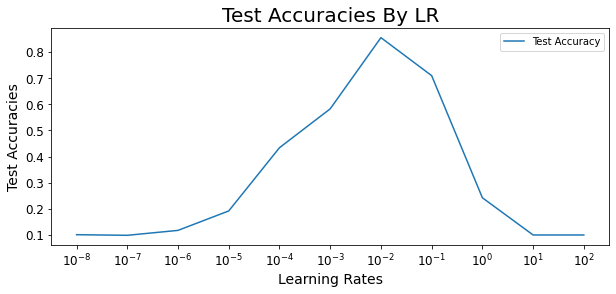

In [8]:
import json

import matplotlib.pyplot as plt
%matplotlib inline

lr_test_results = json.load( open(anlt_folder+"lr_range_test_values.json","r"))
analytics.plot_lr_range_test(*lr_test_results)


## Check Model Parameter Count

In [22]:
from torchsummary import summary
summary(model_class().to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## Download Data Once Again

In [5]:
train_loader, test_loader, classes = prep.get_cifar10_loaders(root="./data", device=device, train_batch_size=512)

Files already downloaded and verified
[(0.4913995563983917, 0.48215845227241516, 0.44653093814849854), (0.20230083167552948, 0.19941286742687225, 0.20096157491207123)]
Files already downloaded and verified


## Find Best LR to start with

## Training - 24 Epochs with One Cycle LR policy
Lr Range: 0.001 TO  0.1  (Peaks at 5 epochs)


In [6]:
fn_idx = 0
epochs = 24

acc_recorder_file = acc_recorder_files[fn_idx]
model_file_name = model_file_names[fn_idx]

accuracy_store_path = base_folder+acc_recorder_file
model_sd_save_path = base_folder+model_file_name+"_sd.pth"

model = new_resnet_S11.NewResNet()

loss_func = F.cross_entropy

one_cycle_params = {"max_lr": 0.1, "peak_epoch": 5, "min_lr": 0.001}

loss_func = F.cross_entropy

train_results = helpers.train_epochs(
                    model=model, 
                    device=device, 
                    train_loader=train_loader,
                    test_loader=test_loader, 
                    optimizer=None, 
                    loss_func=loss_func, 
                    epochs=epochs,
                    accuracy_store_path=accuracy_store_path, 
                    model_sd_save_path=model_sd_save_path,
                    save_if_better_acc=True,
                    oclr_params=one_cycle_params)

  0%|          | 0/98 [00:00<?, ?it/s]


LAST RECORDED MAX ACCURACY:  0.0
EPOCH NUM 1,  LR USED: 0.001


loss=2.178973913192749 batch_id=97: 100%|██████████| 98/98 [00:50<00:00,  1.93it/s]


Train Data: Average loss: 0.0044, Accuracy: 11314/50000 (22.6280%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1514, Accuracy: 3318/10000 (33.1800%)

-----------------------------------------------
EPOCH NUM 2,  LR USED: 0.025750000000000002


loss=1.9074385166168213 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]


Train Data: Average loss: 0.0039, Accuracy: 23113/50000 (46.2260%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.9327, Accuracy: 5273/10000 (52.7300%)

-----------------------------------------------
EPOCH NUM 3,  LR USED: 0.0505


loss=1.8186253309249878 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]


Train Data: Average loss: 0.0037, Accuracy: 28388/50000 (56.7760%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.8863, Accuracy: 5723/10000 (57.2300%)

-----------------------------------------------
EPOCH NUM 4,  LR USED: 0.07525000000000001


loss=1.7612028121948242 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]


Train Data: Average loss: 0.0036, Accuracy: 31935/50000 (63.8700%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.8432, Accuracy: 6177/10000 (61.7700%)

-----------------------------------------------
EPOCH NUM 5,  LR USED: 0.1


loss=1.7626501321792603 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]


Train Data: Average loss: 0.0035, Accuracy: 34079/50000 (68.1580%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.8065, Accuracy: 6521/10000 (65.2100%)

-----------------------------------------------
EPOCH NUM 6,  LR USED: 0.09505000000000001


loss=1.7204073667526245 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]


Train Data: Average loss: 0.0034, Accuracy: 36553/50000 (73.1060%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.7504, Accuracy: 7088/10000 (70.8800%)

-----------------------------------------------
EPOCH NUM 7,  LR USED: 0.0901


loss=1.661838173866272 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]


Train Data: Average loss: 0.0033, Accuracy: 38354/50000 (76.7080%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6913, Accuracy: 7707/10000 (77.0700%)

-----------------------------------------------
EPOCH NUM 8,  LR USED: 0.08515


loss=1.6852740049362183 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]


Train Data: Average loss: 0.0033, Accuracy: 39317/50000 (78.6340%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6826, Accuracy: 7787/10000 (77.8700%)

-----------------------------------------------
EPOCH NUM 9,  LR USED: 0.08020000000000001


loss=1.6243703365325928 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]


Train Data: Average loss: 0.0033, Accuracy: 40229/50000 (80.4580%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.7093, Accuracy: 7506/10000 (75.0600%)

-----------------------------------------------
EPOCH NUM 10,  LR USED: 0.07525000000000001


loss=1.6623914241790771 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]


Train Data: Average loss: 0.0032, Accuracy: 41016/50000 (82.0320%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6846, Accuracy: 7767/10000 (77.6700%)

-----------------------------------------------
EPOCH NUM 11,  LR USED: 0.0703


loss=1.6479047536849976 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]


Train Data: Average loss: 0.0032, Accuracy: 41843/50000 (83.6860%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6391, Accuracy: 8246/10000 (82.4600%)

-----------------------------------------------
EPOCH NUM 12,  LR USED: 0.06535


loss=1.611143708229065 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]


Train Data: Average loss: 0.0032, Accuracy: 42580/50000 (85.1600%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6359, Accuracy: 8270/10000 (82.7000%)

-----------------------------------------------
EPOCH NUM 13,  LR USED: 0.0604


loss=1.59186589717865 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]


Train Data: Average loss: 0.0031, Accuracy: 42962/50000 (85.9240%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6344, Accuracy: 8283/10000 (82.8300%)

-----------------------------------------------
EPOCH NUM 14,  LR USED: 0.05545


loss=1.6112768650054932 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]


Train Data: Average loss: 0.0031, Accuracy: 43521/50000 (87.0420%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6169, Accuracy: 8445/10000 (84.4500%)

-----------------------------------------------
EPOCH NUM 15,  LR USED: 0.0505


loss=1.5828367471694946 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]


Train Data: Average loss: 0.0031, Accuracy: 44067/50000 (88.1340%)




Test set: Average loss: 1.6028, Accuracy: 8602/10000 (86.0200%)



  0%|          | 0/98 [00:00<?, ?it/s]

-----------------------------------------------
EPOCH NUM 16,  LR USED: 0.04555


loss=1.6046907901763916 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]


Train Data: Average loss: 0.0031, Accuracy: 44591/50000 (89.1820%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5976, Accuracy: 8658/10000 (86.5800%)

-----------------------------------------------
EPOCH NUM 17,  LR USED: 0.0406


loss=1.5767892599105835 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]


Train Data: Average loss: 0.0031, Accuracy: 44989/50000 (89.9780%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6024, Accuracy: 8606/10000 (86.0600%)

-----------------------------------------------
EPOCH NUM 18,  LR USED: 0.03565


loss=1.5485520362854004 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]


Train Data: Average loss: 0.0031, Accuracy: 45339/50000 (90.6780%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5934, Accuracy: 8696/10000 (86.9600%)

-----------------------------------------------
EPOCH NUM 19,  LR USED: 0.030700000000000005


loss=1.5582923889160156 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]


Train Data: Average loss: 0.0030, Accuracy: 45799/50000 (91.5980%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5872, Accuracy: 8770/10000 (87.7000%)

-----------------------------------------------
EPOCH NUM 20,  LR USED: 0.025749999999999995


loss=1.5616545677185059 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]


Train Data: Average loss: 0.0030, Accuracy: 46163/50000 (92.3260%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5873, Accuracy: 8762/10000 (87.6200%)

-----------------------------------------------
EPOCH NUM 21,  LR USED: 0.0208


loss=1.5543049573898315 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]


Train Data: Average loss: 0.0030, Accuracy: 46439/50000 (92.8780%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5767, Accuracy: 8870/10000 (88.7000%)

-----------------------------------------------
EPOCH NUM 22,  LR USED: 0.015850000000000003


loss=1.5265531539916992 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]


Train Data: Average loss: 0.0030, Accuracy: 46740/50000 (93.4800%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5717, Accuracy: 8915/10000 (89.1500%)

-----------------------------------------------
EPOCH NUM 23,  LR USED: 0.010899999999999993


loss=1.538447380065918 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.92it/s]


Train Data: Average loss: 0.0030, Accuracy: 47008/50000 (94.0160%)




  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5659, Accuracy: 8980/10000 (89.8000%)

-----------------------------------------------
EPOCH NUM 24,  LR USED: 0.005949999999999997


loss=1.5145658254623413 batch_id=97: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]


Train Data: Average loss: 0.0030, Accuracy: 47224/50000 (94.4480%)




Test set: Average loss: 1.5623, Accuracy: 9007/10000 (90.0700%)

-----------------------------------------------
TOTAL TRAINING TIME:  1309.01713514328
LAST 10 EPOCH AVG ACC:  0.8786599999999998
LAST 5 EPOCH AVG ACC:  0.89068
MAX ACCURACY:  0.9007


## Cyclic LR Rates curve

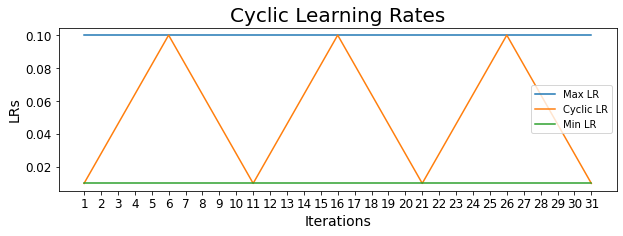

In [44]:
analytics.plot_cyclic_graph(cycles=3, lr_range=(0.01, 0.1), iterations=35)